# Question 2

Does discount have a statistically significant effect on average order revenue per product?

In [1]:
#import libraries
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import statsmodels.api as sm
from statsmodels.formula.api import ols

#For tukey test
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.stats.multicomp import MultiComparison

#For KS Test
from scipy import stats

#For Sampling, Welch's T-Test, Cohen's d - flatiron_stats.py. I have updated with my own functions.
from flatiron_stats import p_value_welch_ttest, welch_t, cohens_d, get_sampling_means

#For SQL Helpter functions
from flatiron_sql import view_table, get_table, get_table_names

#For Power Analysis
from statsmodels.stats.power import TTestIndPower, TTestPower

#significance level
alpha = 0.05

In [2]:
#connect to the Northwind database
conn = sqlite3.connect("Northwind_small.sqlite")

For some orders, a discount is applied to some line items and not others. For this reason, I did not group by OrderId and instead am using individual order line items as orders.

In [3]:
#Need a query which will calculate the total revenue for an order and take into account the discount as well.

#SOME ORDERS HAVE DISCOUNTS FOR ITEMS WITHIN THE ORDER BUT NOT FOR EVERYTHING IN THE ORDER
#Therefore do not group by OrderId

#query = """SELECT *, sum(UnitPrice * Quantity * (1-Discount)) AS TotalPrice
#           FROM OrderDetail
#           GROUP BY OrderId"""

query = """SELECT *, UnitPrice * Quantity * (1-Discount) AS TotalPrice
           FROM OrderDetail
           """
df = pd.read_sql(query,conn)

Preview dataframe structure

In [4]:
df.head()

,Id,OrderId,ProductId,UnitPrice,Quantity,Discount,TotalPrice
0,10248/11,10248,11,14.0,12,0.0,168.0
1,10248/42,10248,42,9.8,10,0.0,98.0
2,10248/72,10248,72,34.8,5,0.0,174.0
3,10249/14,10249,14,18.6,9,0.0,167.4
4,10249/51,10249,51,42.4,40,0.0,1696.0


### Summary Stats for Order Revenue by Discount Level
Run an initial query to look at a summary of the data of interest. I want to see summary statistics for quantity per order grouped by discount amount.

In [5]:
orderPrice = 'UnitPrice * Quantity * (1-Discount)'
query = f"""SELECT Discount, 
                   Round(avg({orderPrice}),2) AS AvgPrice, 
                   Round(min({orderPrice}),2) AS MinPrice,
                   Round(max({orderPrice}),2) AS MaxPrice,
                   count(*) AS NumOrders
            FROM OrderDetail
            GROUP BY Discount
            """
summary_df = pd.read_sql(query,conn)
summary_df

,Discount,AvgPrice,MinPrice,MaxPrice,NumOrders
0,0.00,570.01,4.80,15810.00,1317
1,0.01,29.70,29.70,29.70,1
2,0.02,29.89,24.50,35.28,2
3,0.03,40.30,22.55,64.50,3
4,0.04,77.76,77.76,77.76,1
5,0.05,797.93,28.50,15019.50,185
6,0.06,63.92,63.92,63.92,1
7,0.10,528.90,8.64,3557.25,173
8,0.15,557.36,8.50,3352.40,157
9,0.20,553.92,14.40,8432.00,161


## Hypothesis

**Ho:** There is no difference in the mean total revenue per order between customers who received a discount and those who did not receive a discount.

**Ha:** The mean total revenue per order for those who received a discount will be significantly different than the mean total revenue per order by customers who did not receive a discount. i.e. mean revenue per order for discounted != 570.01. - Two tailed

**Initial thoughts:** Again, I will need to disregard the 0.01, 0.02, 0.03, 0.04, 0.06 discount levels as there is not enough data for them to be used. 

Some discount levels have higher average revenue per order and some have lower. 

In [6]:
#Dropping 0.01, 0.02, 0.03, 0.04, 0.06 discount levels
df = df.drop(df[(df.Discount==0.01)|
                (df.Discount==0.02)|
                (df.Discount==0.03)|
                (df.Discount==0.04)|
                (df.Discount==0.06)].index)

## Visualize the Data

Text(0, 0.5, 'TotalPrice for Order')

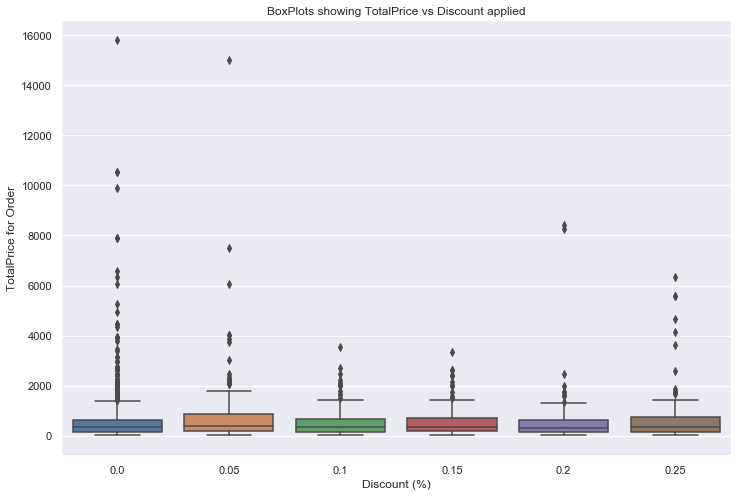

In [7]:
sns.set(rc={'figure.figsize':(12,8)})
sns.boxplot(x='Discount',y='TotalPrice',data=df)
plt.title('BoxPlots showing TotalPrice vs Discount applied')
plt.xlabel('Discount (%)');
plt.ylabel('TotalPrice for Order')

Text(0, 0.5, 'Total Price for Order')

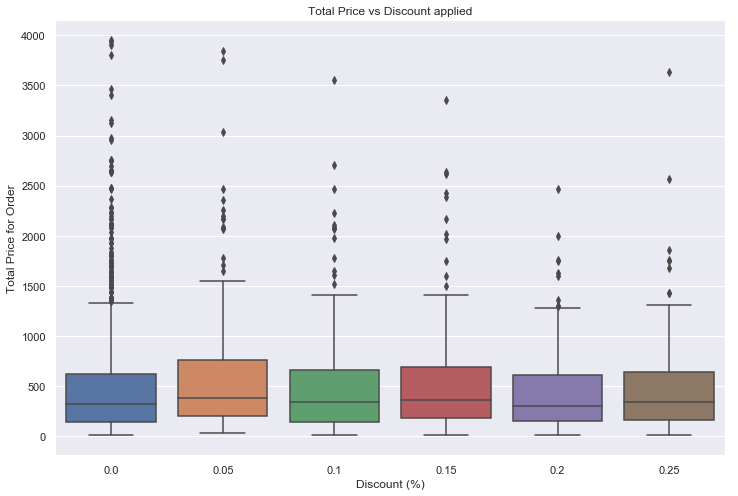

In [8]:
#Drop orders greater than $4000 OUTLIERS
df_dropped = df[df.TotalPrice<4000]

sns.set(rc={'figure.figsize':(12,8)})
sns.boxplot(x='Discount',y='TotalPrice',data=df_dropped)
plt.title('Total Price vs Discount applied')
plt.xlabel('Discount (%)');
plt.ylabel('Total Price for Order')

It looks as though there is some slight variation between the discount levels. Will perform ANOVA and Tukey tests.

## ANOVA Test

In [9]:
#ANOVA TEST
formula = "TotalPrice ~ C(Discount)"
lm = ols(formula, df).fit()
table = sm.stats.anova_lm(lm, typ=2)
table['reject_null'] = table['PR(>F)'] < alpha
print(table)

                   sum_sq      df         F    PR(>F)  reject_null
C(Discount)  9.970778e+06     5.0  2.122947  0.060007        False
Residual     2.011113e+09  2141.0       NaN       NaN        False


Discount does not have a statistically significant effect on Order revenue. **Fail to reject Null Hypothesis Ho.** 
However, I will look into each discount level individually to see if there is a statistically significant correlation.

## Tukey Test

Check individual discount levels

In [10]:
#TUKEY TEST
mc = MultiComparison(df['TotalPrice'], df['Discount'])
result = mc.tukeyhsd()
print("Groups are Discount amounts, summary stats are Order Price\n")
#Convert result to dataframe for prettiness and to only show the comparisons that include no-discount
result_df = pd.DataFrame(data=result._results_table.data[1:], columns=result._results_table.data[0])
print("\nMultiple Comparison of Means - Tukey HSD,FWER=0.05")
#result_df.rename(columns={'group1': 'NoDiscount', 'group2': 'Discount'}, inplace=True)
result_df[result_df.group1==0.00]

Groups are Discount amounts, summary stats are Order Price


Multiple Comparison of Means - Tukey HSD,FWER=0.05


,group1,group2,meandiff,lower,upper,reject
0,0.0,0.05,227.9252,10.8774,444.9730,True
1,0.0,0.10,-41.1098,-264.6607,182.4411,False
2,0.0,0.15,-12.6424,-246.0447,220.7600,False
3,0.0,0.20,-16.0866,-246.8839,214.7106,False
4,0.0,0.25,72.4517,-162.9732,307.8765,False


Whoa, this is cool. The Tukey test tells me that the 0.05 discount level has a statistically significant impact on order revenue. 

**Reject Null Hypothesis Ho for 5% discount level.**

## NORMALITY
Full Price vs Discounted 5%

In [11]:
full_price = df[df['Discount']==0]
#discounted = 5% level
discounted = df[df['Discount']==0.05]

/Users/dennistrimarchi/anaconda3/envs/learn-env/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


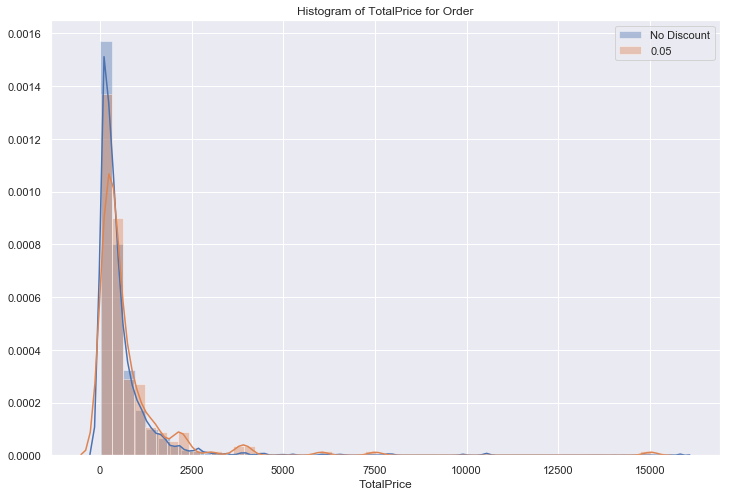

In [12]:
sns.set(rc={'figure.figsize':(12,8)})
sns.distplot(full_price['TotalPrice'], label='No Discount')
sns.distplot(discounted['TotalPrice'], label='0.05')
plt.title('Histogram of TotalPrice for Order')
plt.legend()

### KS Test
Check if each sample is normal

In [13]:
mu = full_price['TotalPrice'].mean()
std = full_price['TotalPrice'].std()
result = stats.kstest(rvs=full_price['TotalPrice'],cdf='norm',args=(mu, std))
print("KS TEST FULL PRICE\ntest statistic: {}\npvalue: {}\nIs Normal: {}".format(result.statistic,result.pvalue,result.pvalue>0.05))

KS TEST FULL PRICE
test statistic: 0.2794706160078528
pvalue: 0.0
Is Normal: False


In [14]:
mu = discounted['TotalPrice'].mean()
std = discounted['TotalPrice'].std()
result = stats.kstest(rvs=discounted['TotalPrice'],cdf='norm',args=(mu, std))
print("KS TEST DISCOUNTED\ntest statistic: {}\npvalue: {}\nIs Normal: {}".format(result.statistic,result.pvalue,result.pvalue>0.05))

KS TEST DISCOUNTED
test statistic: 0.29628424123236663
pvalue: 6.8833827526759706e-15
Is Normal: False


The samples are not normal according to Kolmogorov-Smirnov Test. Will do some sampling in order to create normality according to the Central Limit Theorem.

### Shapiro Test
Checks if each sample is normal

In [15]:
result = stats.shapiro(full_price['TotalPrice'])
print("SHAPIRO TEST FULL PRICE\ntest statistic: {}\npvalue: {}\nIs Normal: {}".format(result[0],result[1],result[1]>0.05))

SHAPIRO TEST FULL PRICE
test statistic: 0.45755600929260254
pvalue: 0.0
Is Normal: False


In [16]:
result = stats.shapiro(discounted['TotalPrice'])
print("SHAPIRO TEST DISCOUNTED\ntest statistic: {}\npvalue: {}\nIs Normal: {}".format(result[0],result[1],result[1]>0.05))

SHAPIRO TEST DISCOUNTED
test statistic: 0.4443626403808594
pvalue: 1.0444835507210095e-23
Is Normal: False


The samples are not normal according to Kolmogorov-Smirnov Test. Will do some sampling in order to create normality according to the Central Limit Theorem.

## Sampling Distributions

Number of Samples: 500
Sample Size: 50

Sampling mean of each group.
Full price: 569.1105659999998
Discounted: 785.07424832
Mean Difference: 215.9636823200002

StdDev of Sample means for each group.
Full price: 140.46558037363786
Discounted: 199.56311070450738


/Users/dennistrimarchi/anaconda3/envs/learn-env/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


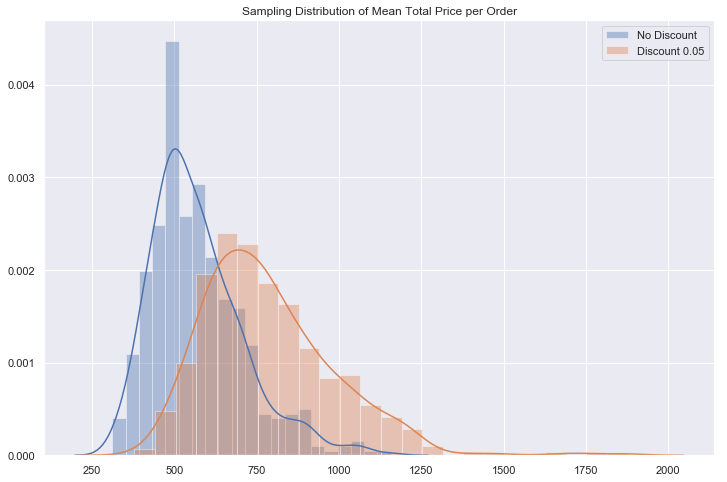

In [17]:
num_samples = 500
sample_size = 50

#Get sample means for each group
full_price_sample_means = get_sampling_means(full_price['TotalPrice'],num_samples,sample_size)
discounted_sample_means = get_sampling_means(discounted['TotalPrice'],num_samples,sample_size)

sns.set(rc={'figure.figsize':(12,8)});
sns.distplot(full_price_sample_means, label='No Discount');
sns.distplot(discounted_sample_means, label='Discount 0.05');
plt.title('Sampling Distribution of Mean Total Price per Order');
plt.legend();

print("Number of Samples: {}\nSample Size: {}\n".format(num_samples,sample_size))
print("Sampling mean of each group.\nFull price: {}\nDiscounted: {}"
      .format(np.mean(full_price_sample_means),np.mean(discounted_sample_means)))
print("Mean Difference: {}\n"
      .format(abs(np.mean(full_price_sample_means)-np.mean(discounted_sample_means))))
print("StdDev of Sample means for each group.\nFull price: {}\nDiscounted: {}"
      .format(np.std(full_price_sample_means),np.std(discounted_sample_means)))

## Welch's T-Test

Raw Data:

In [18]:
#Welch's T-Test on original dataset before sampling
p_orig = p_value_welch_ttest(full_price['TotalPrice'],discounted['TotalPrice'], two_sided=True)
t_orig = welch_t(full_price['TotalPrice'],discounted['TotalPrice'])
print("Welch's T-Test:\nt: {}  p-val: {}  reject null: {}".format(t_orig,p_orig,p_orig<alpha))

Welch's T-Test:
t: 2.0913780231378394  p-val: 0.037709870639518694  reject null: True


Sampled Data:

In [19]:
p = p_value_welch_ttest(full_price_sample_means, discounted_sample_means, two_sided=True)
t = welch_t(full_price_sample_means, discounted_sample_means)

print("Welch's T-Test:\nt: {}  p-val: {}  reject null: {}".format(t,p,p<alpha))

Welch's T-Test:
t: 19.76824812055224  p-val: 0.0  reject null: True


Like the Tukey test, the **Null Hypothesis is rejected** for the 5% discount level... barely.

## Effect Size

Raw Data:

In [20]:
#Effect size of original dataset before sampling
d_orig = cohens_d(full_price['TotalPrice'],discounted['TotalPrice'])
print("Effect Size d: {}".format(d_orig))

Effect Size d: 0.22091426590046287


Sampled Data:

In [21]:
d = cohens_d(full_price_sample_means, discounted_sample_means)
print("Effect Size d: {}".format(d))

Effect Size d: 1.250253788245758


## Summary / Conclusion

Discount has a statistically significant effect on order revenue for the 5% discount level. For all other discount levels, the Null Hypothesis failed to be rejected.

The following table shows the 5% discount level, mean difference and effect size with respect to the full price group.

|Discount | Mean Difference | Effect Size | 
|---------|-----------------|-------------|
| 0.05    |    227.92       |     0.221   |

This was a two-tailed test, but we can see that the mean revenue is greater for the 5% discount level. The effect of the discount is small according to Cohen's d effect size measurement.

## Recommendations
Based on these results I would recommend that the company consider that a 5% discount results in greater revenue per order.

This may be due to a combination of the customer ordering more product because of the presence of the discount, and the discount being small enough to limit negative impact to revenue.

Additionally, the tests also show that applying other discount levels do not negatively impact average order revenue. 


## Statistical Power

In [22]:
#Get effect sizes for various values of n

Sample size = 50
Effect size = 1.25
Power       = 1.0


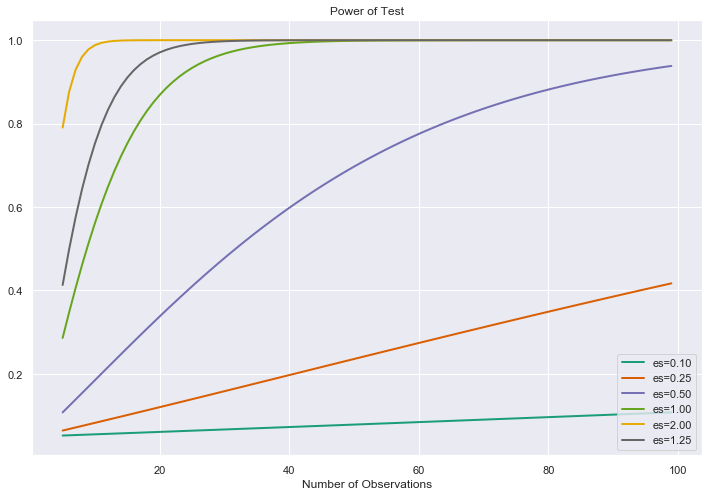

Effect size needed to get power=0.8: 0.5658803032224228


In [23]:
power_analysis = TTestIndPower()
power = power_analysis.solve_power(effect_size=d,nobs1=sample_size,alpha=alpha)
print("Sample size = {}\nEffect size = {}\nPower       = {}".format(sample_size, np.round(d,3), np.round(power,3)))

power_analysis.plot_power(dep_var='nobs',
                         nobs=np.array(range(5,100)),
                         effect_size=[0.1,0.25,0.5,1.0,2.0,d],
                         alpha=alpha)
plt.show()

effect_size_needed = power_analysis.solve_power(power=0.8,nobs1=sample_size,alpha=alpha)
print("Effect size needed to get power=0.8: {}".format(effect_size_needed))